<a href="https://colab.research.google.com/github/dubisx/EMCT_final/blob/main/Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Download dependencies (run once)


!pip install miditok
!pip install tokenizers
!pip install transformers
!pip install pretty_midi
!pip install librosa

print('Done!')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.4/94.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 2.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 4.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 86.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=55

In [2]:
#@title Import dependencies (run once)

print('Importing dependencies...')
print('')

import tensorflow as tf
from tensorflow import keras
import numpy
import miditok
import tqdm
from miditok import MIDILike, MIDITokenizer, OctupleMono, REMI
import pathlib
from miditok.constants import CHORD_MAPS
from transformers import TFGPT2LMHeadModel, GPT2Config, Trainer, TrainingArguments, GenerationConfig, pipeline
from miditoolkit import MidiFile
from pathlib import Path
import pretty_midi
from pretty_midi import PrettyMIDI
import librosa.display
import matplotlib.pyplot as plt
import IPython.display
import copy

print('Done!')

Importing dependencies...

Done!


In [3]:
#@title Connect to Google Drive (run once)

print('Mounting Google Drive..')
print('')

from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounting Google Drive..

Mounted at /content/gdrive


In [4]:
#@title Define function for plotting piano roll

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))
    
print('Done!')

Done!


In [5]:
#@title Initialize model and tokenizer (25attn model works best, but feel free to experiment with the other two)

attn_window = 25 #@param [10, 25, 50] {type:"raw"}

print('Initializing tokenizer...')
print('')

#initializes tokenizer
tokenizer = REMI(params = "/content/gdrive/MyDrive/ala/REMI/params.json") #Loads parameters from a specified path for the tokenizer

print('Tokenizer loaded!')

print('------')

print('Initializing model...')

# Creates model
config = GPT2Config( 
    vocab_size=1000,
    n_positions=attn_window,
    n_embd=64,
    n_layer=4,
    n_head=4,
    n_inner=128,
    resid_pdrop=.1,
    embd_pdrop=.1,
    attn_pdrop=.1,
    pad_token_id=tokenizer['PAD_None'],
    bos_token_id=tokenizer['BOS_None'],
    eos_token_id=tokenizer['EOS_None'],
)
model = TFGPT2LMHeadModel(config) 

print('Loading model parameters and weights...')
print('')

model_path = '/content/gdrive/MyDrive/model_f/REMI_FD_model_25attn'#@param {type:"string"} 
weights_path = '/content/gdrive/MyDrive/model_f/REMI_weights_25attn' #@param {type:"string"} 
model.from_pretrained(model_path)
model.load_weights(weights_path)    

print('Model parameters and weights loaded!')

# defining our optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
# definining our loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# defining our metric which we want to observe
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# compiling the model
model.compile(optimizer=optimizer, loss=[loss, *[None] * model.config.n_layer], metrics=[metric])

print('------')
print('')
print('Model initialized!')

Initializing tokenizer...

Tokenizer loaded!
------
Initializing model...
Loading model parameters and weights...



All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/gdrive/MyDrive/model_f/REMI_FD_model_25attn.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model parameters and weights loaded!
------

Model initialized!


Importing and tokenizing selected MIDI file...

Done!

token: [TokSequence(tokens=['Bar_None', 'Position_0', 'Tempo_128', 'Pitch_39', 'Velocity_99', 'Duration_2.0.8', 'Pitch_51', 'Velocity_99', 'Duration_2.0.8', 'Pitch_63', 'Velocity_99', 'Duration_2.0.8', 'Pitch_87', 'Velocity_99', 'Duration_0.2.8', 'Position_2', 'Tempo_128', 'Pitch_89', 'Velocity_99', 'Duration_0.2.8', 'Position_4', 'Tempo_128', 'Pitch_86', 'Velocity_99', 'Duration_0.4.8', 'Position_8', 'Tempo_128', 'Pitch_84', 'Velocity_99', 'Duration_0.2.8', 'Position_10', 'Tempo_128', 'Pitch_86', 'Velocity_99', 'Duration_0.2.8', 'Position_12', 'Tempo_128', 'Pitch_57', 'Velocity_99', 'Duration_1.0.8', 'Pitch_82', 'Velocity_99', 'Duration_0.4.8', 'Position_18', 'Tempo_128', 'Pitch_89', 'Velocity_99', 'Duration_0.2.8', 'Position_20', 'Tempo_128', 'Pitch_58', 'Velocity_99', 'Duration_0.4.8', 'Pitch_86', 'Velocity_99', 'Duration_0.4.8', 'Position_24', 'Tempo_128', 'Pitch_31', 'Velocity_99', 'Duration_2.0.8', 'Pitch_43', 'Velocity_99', 

<ipython-input-4-6ed42ee27a71>:5: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


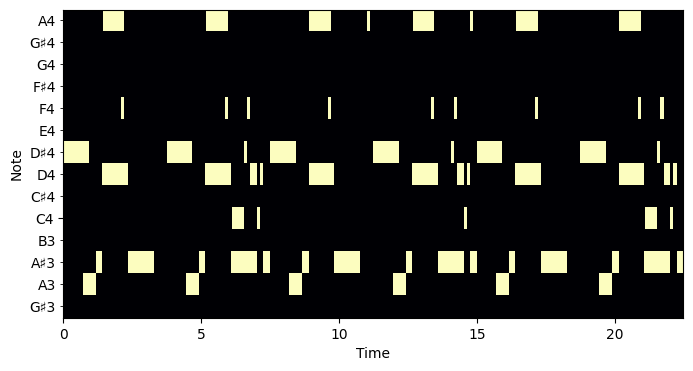

In [12]:
#@title Select MIDI file to use as prompt

midi_path = '/content/gdrive/MyDrive/ala/REMI/test_midi/3.mid' #@param {type:"string"}

print('Importing and tokenizing selected MIDI file...')
print('')

midi = MidiFile(midi_path)
token = tokenizer(midi)  # automatically detects MidiFile, paths or tokens before converting them

print('Done!')
print('')

print('token:', token)
print('')

prompt = [token[0].ids]

#constructing PrettyMIDI objects from the MIDI files
pm = PrettyMIDI(midi_path)

#Plotting original MIDI file
plt.figure(figsize=(8, 4))
plot_piano_roll(pm, 56, 70)

#Playing original MIDI file
fs = 16000
IPython.display.Audio(pm.synthesize(fs=16000), rate=16000)

In [13]:
#@title Configure generation settings and run to generate

generation_config = GenerationConfig(
    max_new_tokens=548 #@param {type:"slider", min:32, max:1024, step:4}
    , num_beams=1,        # no beam search
    do_sample=True,     # but sample instead
    temperature=0.83 #@param {type:"slider", min:0.01, max:1.0, step:0.01}
    , top_k=15,
    top_p=0.95,
    epsilon_cutoff=3e-4,
    eta_cutoff=1e-3,
)

print('input tokens:', token[0].ids)

print('Generating new token sequence...')
print('')

outputs = model.generate(prompt, generation_config)

print('Done!')

outputs = tf.Variable(outputs).numpy().tolist()
print('generated tokens:', outputs)

input tokens: [412, 22, 364, 34, 364, 46, 364, 70, 340, 984, 72, 340, 493, 69, 337, 444, 67, 340, 884, 69, 340, 481, 40, 344, 740, 834, 72, 340, 473, 694, 69, 337, 420, 14, 364, 26, 364, 45, 364, 52, 860, 67, 340, 823, 69, 340, 499, 740, 412, 70, 340, 984, 72, 340, 493, 877, 69, 337, 444, 17, 364, 29, 364, 41, 364, 53, 860, 67, 340, 884, 69, 340, 481, 740, 433, 67, 340, 834, 72, 340, 473, 880, 69, 337, 420, 867, 67, 340, 213, 324, 57, 384, 823, 65, 340, 499, 64, 340, 218, 324, 65, 340, 412, 22, 364, 34, 364, 46, 364, 70, 340, 984, 72, 340, 493, 69, 337, 444, 67, 340, 884, 69, 340, 481, 40, 344, 740, 834, 72, 340, 473, 694, 69, 337, 420, 14, 364, 26, 364, 45, 364, 52, 860, 67, 340, 823, 69, 340, 499, 740, 412, 70, 340, 984, 72, 340, 493, 877, 69, 337, 444, 17, 364, 29, 364, 41, 364, 43, 344, 53, 860, 67, 340, 884, 69, 340, 481, 740, 433, 46, 340, 67, 340, 834, 877, 72, 340, 473, 806, 880, 69, 337, 420, 856, 867, 67, 340, 213, 324, 57, 384, 823, 897, 65, 340, 499, 694, 64, 340, 218, 324,

In [14]:
#@title Convert generated token sequence to MIDI and save to path

generated_midi_path = '/content/gdrive/MyDrive/ala/REMI/generated_midi/REMI9.mid' #@param {type:"string"}

#truncate the lenght of prompt from the beginning of the generated sequence, and until the token with value of 356 is reached
save_continuation_only = True #@param {type:"boolean"}

if save_continuation_only == True:
  outputs_trun = tf.Variable(outputs).numpy().tolist()
  outputs_trun[0] = outputs[0][len(prompt[0]):]

  for i in range(len(outputs_trun[0])):
      if outputs_trun[0][i] == 356:
          outputs_trun[0] = outputs_trun[0][i:]
          break
else:
  outputs_trun = copy.copy(outputs)

#Converting tokens to MIDI and saving to drive
print('Saving MIDI file...')
print('')

generated_midi = tokenizer(outputs_trun)
generated_midi.dump(generated_midi_path)

print('Saved MIDI file to:', generated_midi_path)

Saving MIDI file...

Saved MIDI file to: /content/gdrive/MyDrive/ala/REMI/generated_midi/REMI9.mid


<ipython-input-4-6ed42ee27a71>:5: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


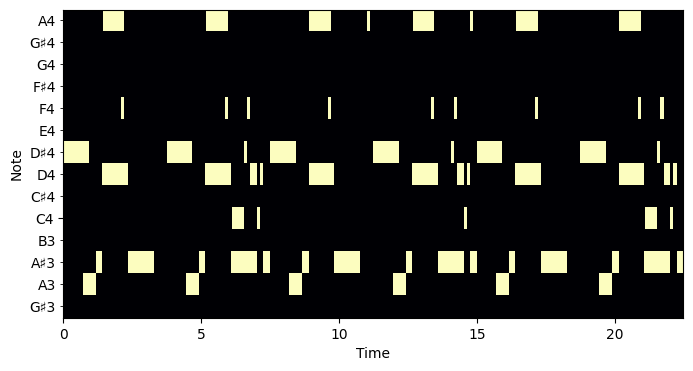

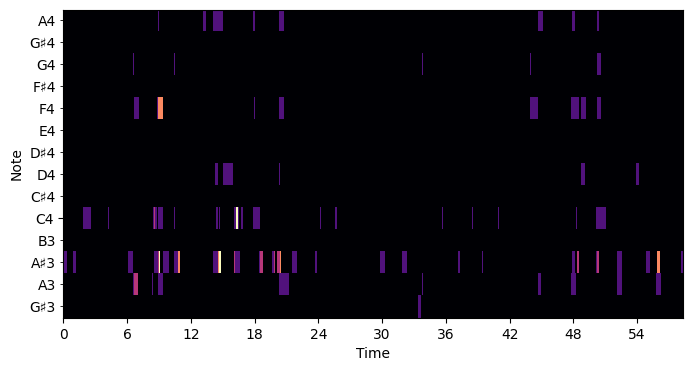

In [15]:
#@title Plot original and generated MIDI 

import matplotlib.pyplot as plt
import pretty_midi

#constructing PrettyMIDI objects from the MIDI files
pm1 = PrettyMIDI(generated_midi_path)

#Plotting original MIDI file
plt.figure(figsize=(8, 4))
plot_piano_roll(pm, 56, 70)

#Plotting generated MIDI file
plt.figure(figsize=(8, 4))
plot_piano_roll(pm1, 56, 70)

In [16]:
#@title Play the generated MIDI
IPython.display.Audio(pm1.synthesize(fs=16000), rate=16000)




In [25]:
#@title Download generated MIDI

from google.colab import files
files.download(generated_midi_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>